In [1]:
import pandas as pd
import numpy as np
import pymannkendall as mk
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
sys.path.append(os.path.abspath('E:/portneuf/analysis/utils/'))
import trend_sen
import contextily as ctx

In [2]:
grph_dir = os.path.join(os.path.join(os.getcwd(), 'graphics'))
os.makedirs(grph_dir, exist_ok=True)

In [3]:
df = pd.read_csv('gridMET_HUC12_monthly_stats.csv')
df['tmmn'] = df['tmmn'] - 273.15
df['tmmx'] = df['tmmx'] - 273.15
df['tmean'] = df[['tmmn', 'tmmx']].mean(axis=1)

In [4]:
df

,Date,huc12,pr,etr,tmmn,tmmx,tmean
0,1999-01-01,170402080608,39.060099,29.871449,-5.685159,2.423049,-1.631055
1,1999-01-01,170402080102,64.428112,25.744536,-7.654450,0.231969,-3.711241
2,1999-01-01,170402080104,102.146274,25.714261,-7.768679,-0.601728,-4.185203
3,1999-01-01,170402080106,53.634767,27.612401,-7.442584,-0.207157,-3.824871
4,1999-01-01,170402080107,45.239523,31.851244,-7.942996,0.459019,-3.741989
...,...,...,...,...,...,...,...
13795,2023-12-01,170402080401,65.066793,29.867497,-7.340612,2.147381,-2.596615
13796,2023-12-01,170402080403,84.826814,29.918535,-7.078321,1.851950,-2.613186
13797,2023-12-01,170402080205,68.954814,29.568637,-8.488046,1.056108,-3.715969
13798,2023-12-01,170402080402,97.918302,29.801979,-6.108928,1.953337,-2.077796


In [5]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df[['month', 'year', 'irr_year']] = df.apply(trend_sen.irr_year, axis=1, result_type='expand')

In [6]:
df = df[df['irr_year'] >= 2000]

In [14]:
df.groupby(['huc12', 'irr_year'])['etr'].sum().reset_index().groupby('irr_year').mean().reset_index().sort_values('irr_year')

,irr_year,huc12,etr
0,2000,1.704021e+11,1762.019724
1,2001,1.704021e+11,1711.775918
2,2002,1.704021e+11,1613.550587
3,2003,1.704021e+11,1712.460988
4,2004,1.704021e+11,1522.554167
5,2005,1.704021e+11,1526.999314
6,2006,1.704021e+11,1590.629144
7,2007,1.704021e+11,1725.909607
8,2008,1.704021e+11,1654.884664
9,2009,1.704021e+11,1476.833388


In [17]:
df_cs = df[df['month'].isin([4, 5, 6, 7, 8, 9, 10])].copy() # April to October
df_non_cs = df[~df['month'].isin([4, 5, 6, 7, 8, 9, 10])].copy() # November to March

In [18]:
var_cols = ['pr', 'etr', 'tmmn', 'tmmx', 'tmean']
et_model_names = {
'pr': ' Precip',
'etr': 'Evaporative demand (tall)',
'tmean': 'Mean temp',
'tmmn': 'Min. temp',
'tmmx': 'Max.temp',
}

In [19]:
df_irr_yr = df.groupby(['huc12', 'irr_year',]).agg(
    pr = ('pr', 'sum'),
    etr = ('etr', 'sum'),
    tmmx = ('tmmx', 'mean'),
    tmmn = ('tmmn', 'mean'),
    tmean = ('tmean', 'mean'),
).reset_index()

df_cs_yr = df_cs.groupby(['huc12', 'year',]).agg(
    pr = ('pr', 'sum'),
    etr = ('etr', 'sum'),
    tmmx = ('tmmx', 'mean'),
    tmmn = ('tmmn', 'mean'),
    tmean = ('tmean', 'mean'),
).reset_index()

df_non_cs_yr = df_non_cs.groupby(['huc12', 'year',]).agg(
    pr = ('pr', 'sum'),
    etr = ('etr', 'sum'),
    tmmx = ('tmmx', 'mean'),
    tmmn = ('tmmn', 'mean'),
    tmean = ('tmean', 'mean'),
).reset_index()

In [20]:
# agg_df = df.groupby(['huc12', 'irr_year']).agg(
#     ppt_total=('pr', 'sum'),  # Total precipitation over the irrigation year
#     ppt_std=('pr', 'std'),
#     ppt_cv=('pr', lambda x: x.std() / x.mean() if x.mean() != 0 else np.nan),
#     tmin_mean=('tmmn', 'mean'),
#     tmin_std=('tmmn', 'std'),
#     tmin_cv=('tmmn', lambda x: x.std() / x.mean() if x.mean() != 0 else np.nan),
#     tmax_mean=('tmmx', 'mean'),
#     tmax_std=('tmmx', 'std'),
#     tmax_cv=('tmmx', lambda x: x.std() / x.mean() if x.mean() != 0 else np.nan),
#     tavg_mean=('tmean', 'mean'),
#     tavg_std=('tmean', 'std'),
#     tavg_cv=('tmean', lambda x: x.std() / x.mean() if x.mean() != 0 else np.nan),
#     et_total=('etr', 'sum'),  # Total evapotranspiration over the irrigation year
#     et_std=('etr', 'std'),
#     et_cv=('etr', lambda x: x.std() / x.mean() if x.mean() != 0 else np.nan)
# ).reset_index()


In [21]:
# Step 1: Aggregation by HUC12 and Irrigation Year for seasonal variability
agg_irr_year = df.groupby(['huc12', 'irr_year']).agg(
    ppt_total=('pr', 'sum'),
    ppt_std=('pr', 'std'),
    ppt_cv=('pr', lambda x: x.std() / x.mean() if x.mean() != 0 else np.nan),
    tmin_mean=('tmmn', 'mean'),
    tmin_std=('tmmn', 'std'),
    tmin_cv=('tmmn', lambda x: x.std() / x.mean() if x.mean() != 0 else np.nan),
    tmax_mean=('tmmx', 'mean'),
    tmax_std=('tmmx', 'std'),
    tmax_cv=('tmmx', lambda x: x.std() / x.mean() if x.mean() != 0 else np.nan),
    et_total=('etr', 'sum'),
    et_std=('etr', 'std'),
    et_cv=('etr', lambda x: x.std() / x.mean() if x.mean() != 0 else np.nan)
).reset_index()

agg_irr_year = agg_irr_year[agg_irr_year['irr_year'] != 2024]

# Step 2: Aggregating by HUC12 for long-term mean, std, and CV for interannual variability
agg_long_term = agg_irr_year.groupby('huc12').agg(
    # Long-term mean of precipitation (total sum of ppt across irrigation years)
    ppt_mean=('ppt_total', 'mean'),
    ppt_std=('ppt_total', 'std'),
    ppt_cv=('ppt_total', lambda x: x.std() / x.mean() if x.mean() != 0 else np.nan),
    
    # Long-term mean for temperature (min)
    tmin_mean=('tmin_mean', 'mean'),
    tmin_std=('tmin_mean', 'std'),
    tmin_cv=('tmin_mean', lambda x: x.std() / x.mean() if x.mean() != 0 else np.nan),
    
    # Long-term mean for temperature (max)
    tmax_mean=('tmax_mean', 'mean'),
    tmax_std=('tmax_mean', 'std'),
    tmax_cv=('tmax_mean', lambda x: x.std() / x.mean() if x.mean() != 0 else np.nan),
    
    # Long-term mean of evapotranspiration (ET total)
    et_mean=('et_total', 'mean'),
    et_std=('et_total', 'std'),
    et_cv=('et_total', lambda x: x.std() / x.mean() if x.mean() != 0 else np.nan)
).reset_index()



In [156]:
agg_irr_year

,huc12,irr_year,ppt_total,ppt_std,ppt_cv,tmin_mean,tmin_std,tmin_cv,tmax_mean,tmax_std,tmax_cv,et_total,et_std,et_cv
0,170402080101,2000,386.161171,18.559505,0.576739,0.360077,7.005186,19.454703,14.256611,10.351922,0.726114,1622.965989,89.195730,0.659502
1,170402080101,2001,281.120027,8.129000,0.346998,-0.897749,9.035608,-10.064741,13.214885,12.019960,0.909577,1587.927576,94.003183,0.710384
2,170402080101,2002,409.171374,18.145005,0.532149,-1.215022,8.619983,-7.094509,12.280621,11.438862,0.931456,1500.199588,89.944571,0.719461
3,170402080101,2003,329.407744,11.671342,0.425176,0.811826,7.355035,9.059864,14.246103,10.668488,0.748871,1577.909530,89.728041,0.682382
4,170402080101,2004,560.963109,18.960935,0.405608,-0.043876,7.526852,-171.547565,12.398091,10.311554,0.831705,1408.990606,75.633142,0.644147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1144,170402080608,2019,329.882140,21.198666,0.771136,0.457654,7.668151,16.755333,14.295310,11.266057,0.788095,1591.675847,93.466922,0.704668
1145,170402080608,2020,236.136530,15.691788,0.797426,1.047385,6.984701,6.668707,15.984419,10.722756,0.670826,1696.311027,89.271323,0.631521
1146,170402080608,2021,253.283099,16.489065,0.781216,1.777735,7.766789,4.368925,16.336830,11.307491,0.692147,1730.514505,94.195593,0.653186
1147,170402080608,2022,233.494216,11.283135,0.579876,0.869570,8.378165,9.634832,15.596287,11.961450,0.766942,1610.280851,88.969080,0.663008


In [22]:
agg_long_term

,huc12,ppt_mean,ppt_std,ppt_cv,tmin_mean,tmin_std,tmin_cv,tmax_mean,tmax_std,tmax_cv,et_mean,et_std,et_cv
0,170402080101,486.064820,114.547935,0.235664,0.094668,0.801904,8.470719,12.851775,0.812583,0.063227,1491.202932,80.986514,0.054310
1,170402080102,533.029016,126.106235,0.236584,-0.029776,0.786047,-26.398510,12.689820,0.820244,0.064638,1507.627459,85.156464,0.056484
2,170402080103,801.497706,192.173395,0.239768,0.903211,0.888145,0.983320,11.893461,0.862344,0.072506,1550.581745,94.000524,0.060623
3,170402080104,754.736254,172.971377,0.229181,0.083699,0.802668,9.589966,11.653615,0.811469,0.069632,1487.050820,87.834888,0.059067
4,170402080105,461.480491,112.007182,0.242713,-0.531094,0.766370,-1.443004,13.430555,0.840858,0.062608,1580.140272,94.437847,0.059765
5,170402080106,469.127083,107.571434,0.229301,0.462979,0.826031,1.784164,12.404567,0.837558,0.067520,1538.748463,89.358795,0.058072
6,170402080107,436.597858,102.689686,0.235204,-0.435964,0.799403,-1.833644,13.062061,0.840473,0.064345,1584.852636,97.120043,0.061280
7,170402080108,518.461545,129.543436,0.249861,-0.641502,0.738610,-1.151376,13.671254,0.861438,0.063011,1634.950205,101.229115,0.061916
8,170402080201,502.781770,114.068913,0.226876,-1.170455,0.819856,-0.700459,12.595123,0.828287,0.065763,1563.670243,93.735109,0.059946
9,170402080202,442.415116,106.791898,0.241384,-1.320733,0.801594,-0.606931,13.506895,0.872823,0.064621,1615.420918,103.211112,0.063891


In [58]:
gdf = gpd.read_file('../portneuf_huc12/portneuf_huc12.shp')

In [59]:
# Make sure HUC12 in shapefile and trend_df match in type
gdf['huc12'] = gdf['huc12'].astype(str)
agg_long_term['huc12'] = agg_long_term['huc12'].astype(str)

In [60]:
# Merge the long-term statistics with the HUC12 GeoDataFrame (huc12_gdf)
huc12_gdf = gdf.merge(agg_long_term, on='huc12', how='left')

In [127]:
def plot_gdf(
    gdf,
    column,
    cmap='Blues',
    edgecolor='gray',
    linewidth=0.5,
    legend_label=None,
    basemap=False,
    basemap_source=ctx.providers.CartoDB.Positron,
    figsize=(12, 10),
    title=None,
    save_path=None,
    dpi=300
):
    """
    Plot a GeoDataFrame with optional basemap and save.

    Parameters:
    - gdf: GeoDataFrame to plot.
    - column: Name of the numeric column to visualize.
    - cmap: Matplotlib colormap name.
    - edgecolor, linewidth: styling for polygon outlines.
    - legend_label: Label for the colorbar (e.g. 'Mean Precipitation (mm)').
    - basemap: If True, reproject to EPSG:3857 and add a base map.
    - basemap_source: contextily tile provider.
    - figsize: Figure size.
    - title: Plot title (string).
    - save_path: PNG filename to save the figure. If None, does not save.
    - dpi: Resolution when saving.
    """

    # Prepare GeoDataFrame (copy to avoid side effects)
    plot_gdf = gdf.copy()

    fig, ax = plt.subplots(figsize=figsize)

    # Reproject and plot
    if basemap and plot_gdf.crs.to_epsg() != 3857:
        plot_gdf = plot_gdf.to_crs(epsg=3857)

    plot_gdf.plot(
        column=column,
        cmap=cmap,
        linewidth=linewidth,
        edgecolor=edgecolor,
        legend=True,
        legend_kwds={'label': legend_label, 'shrink': 0.8},
        ax=ax
    )
    if basemap:
        # Add basemap
        ctx.add_basemap(ax, source=basemap_source, alpha=0.8)
        #ax.set_axis_off()
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
    # # Aesthetics
    ax.set_axisbelow(True)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    ax.set_facecolor('white')

    if title:
        ax.set_title(title, fontsize=14)

    plt.tight_layout()

    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')

    plt.show()


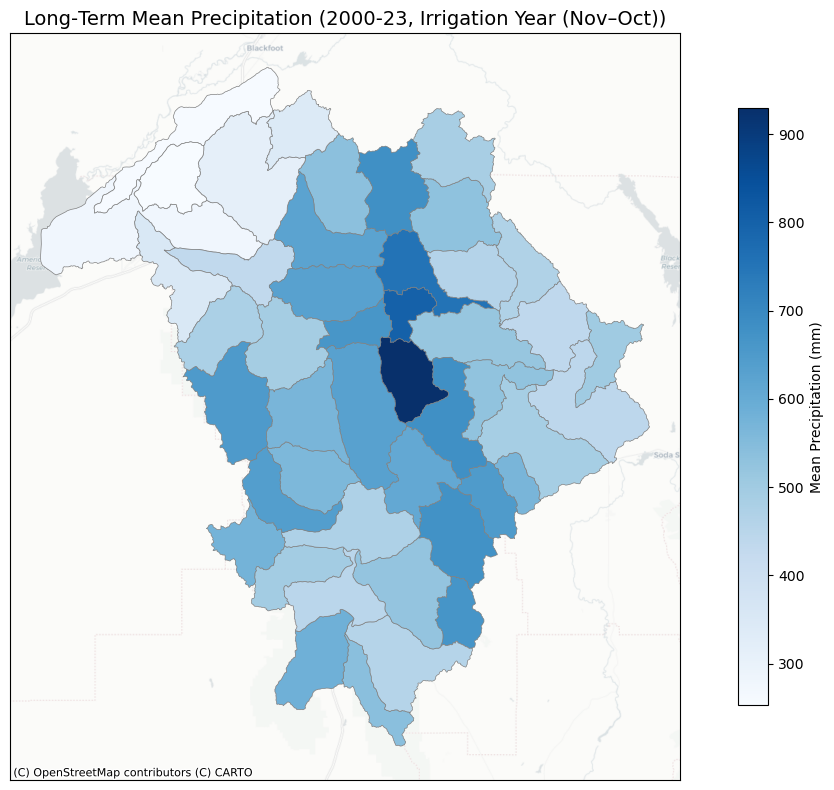

In [145]:
plot_gdf(
    huc12_gdf,
    column='ppt_mean',
    cmap='Blues',
    legend_label='Mean Precipitation (mm)',
    figsize=(12, 8),
    basemap=True,
    save_path='graphics/ppt_mean_gmet_huc12.png', #'ppt_mean_map.png',
    title='Long‑Term Mean Precipitation (2000-23, Irrigation Year (Nov–Oct))'
)


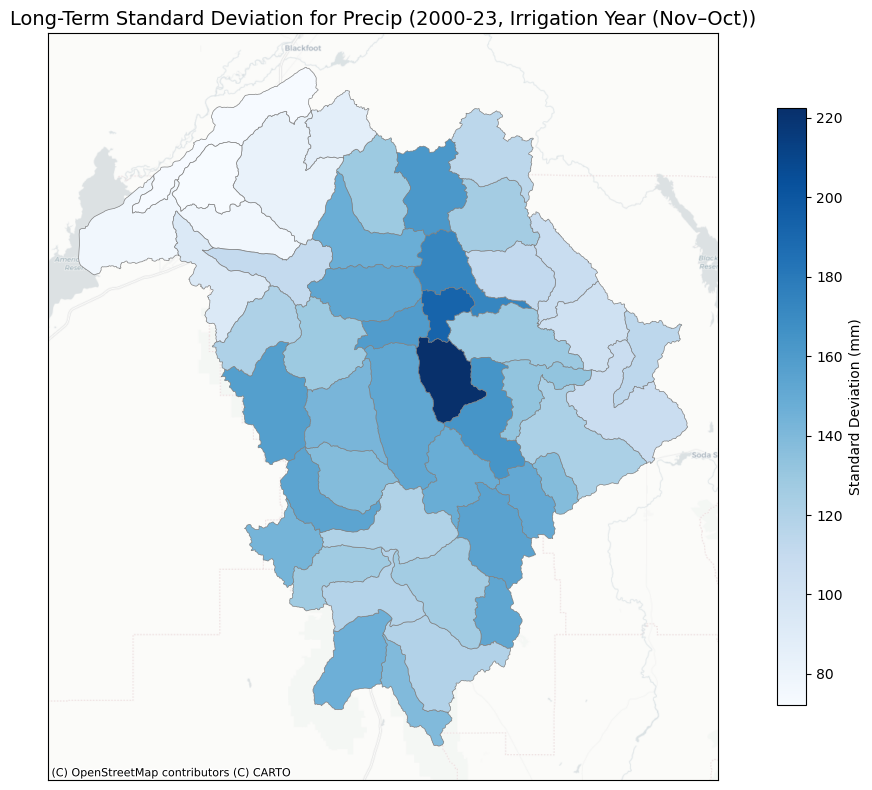

In [146]:
plot_gdf(
    huc12_gdf,
    column='ppt_std',
    cmap='Blues',
    legend_label='Standard Deviation (mm)',
    figsize=(12, 8),
    basemap=True,
    save_path='graphics/ppt_std_gmet_huc12.png', #'ppt_mean_map.png',
    title='Long-Term Standard Deviation for Precip (2000-23, Irrigation Year (Nov–Oct))'
)


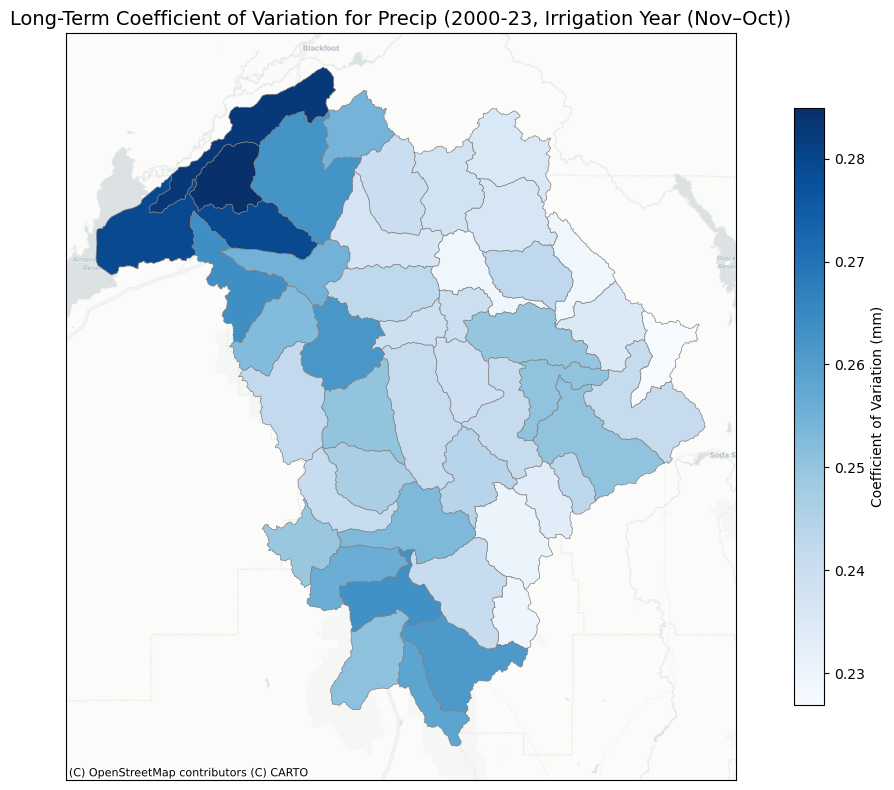

In [147]:
plot_gdf(
    huc12_gdf,
    column='ppt_cv',
    cmap='Blues',
    legend_label='Coefficient of Variation (mm)',
    figsize=(12, 8),
    basemap=True,
    save_path='graphics/ppt_cv_gmet_huc12.png', #'ppt_mean_map.png',
    title='Long-Term Coefficient of Variation for Precip (2000-23, Irrigation Year (Nov–Oct))'
)


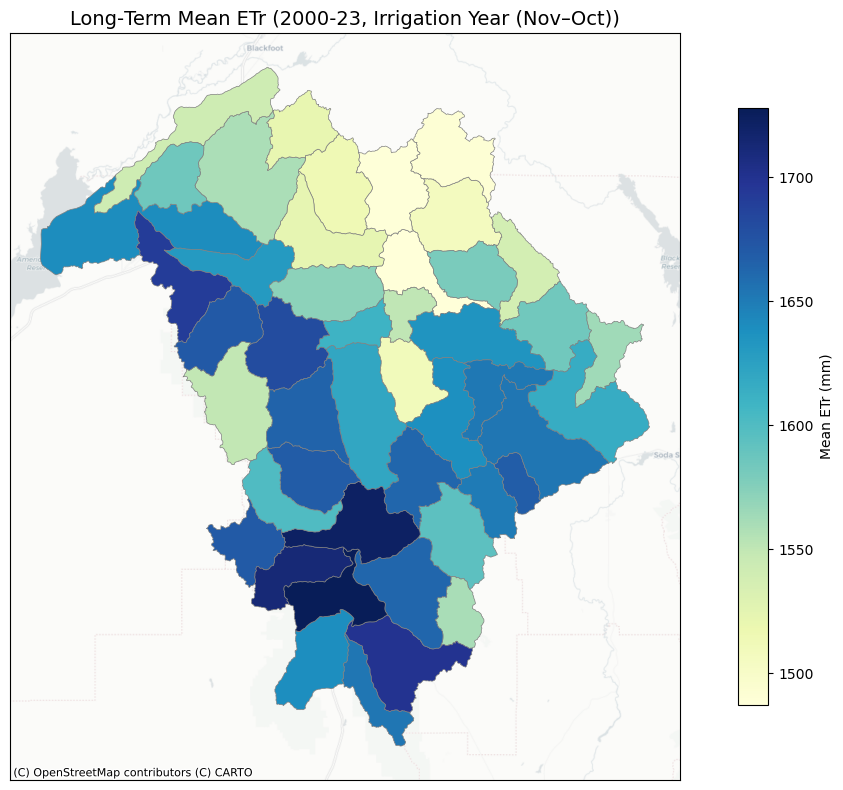

In [148]:
plot_gdf(
    huc12_gdf,
    column='et_mean',
    cmap='YlGnBu',
    legend_label='Mean ETr (mm)',
    figsize=(12, 8),
    basemap=True,
    save_path='graphics/etr_mean_gmet_huc12.png', #'ppt_mean_map.png',
    title='Long‑Term Mean ETr (2000-23, Irrigation Year (Nov–Oct))'
)


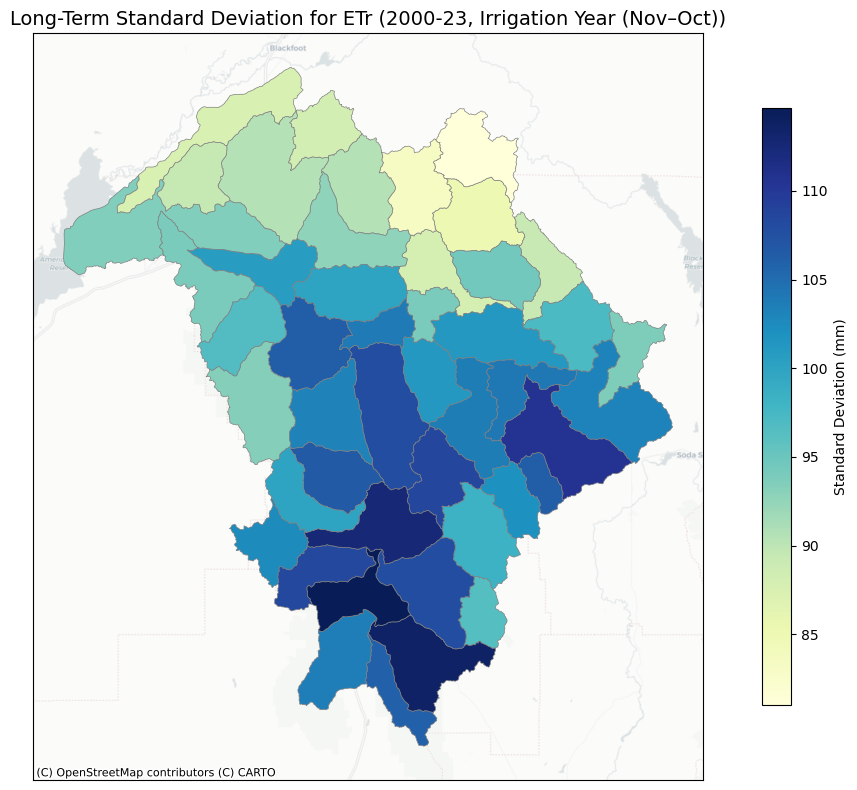

In [149]:
plot_gdf(
    huc12_gdf,
    column='et_std',
    cmap='YlGnBu',
    legend_label='Standard Deviation (mm)',
    figsize=(12, 8),
    basemap=True,
    save_path='graphics/etr_std_gmet_huc12.png', #'ppt_mean_map.png',
    title='Long-Term Standard Deviation for ETr (2000-23, Irrigation Year (Nov–Oct))'
)


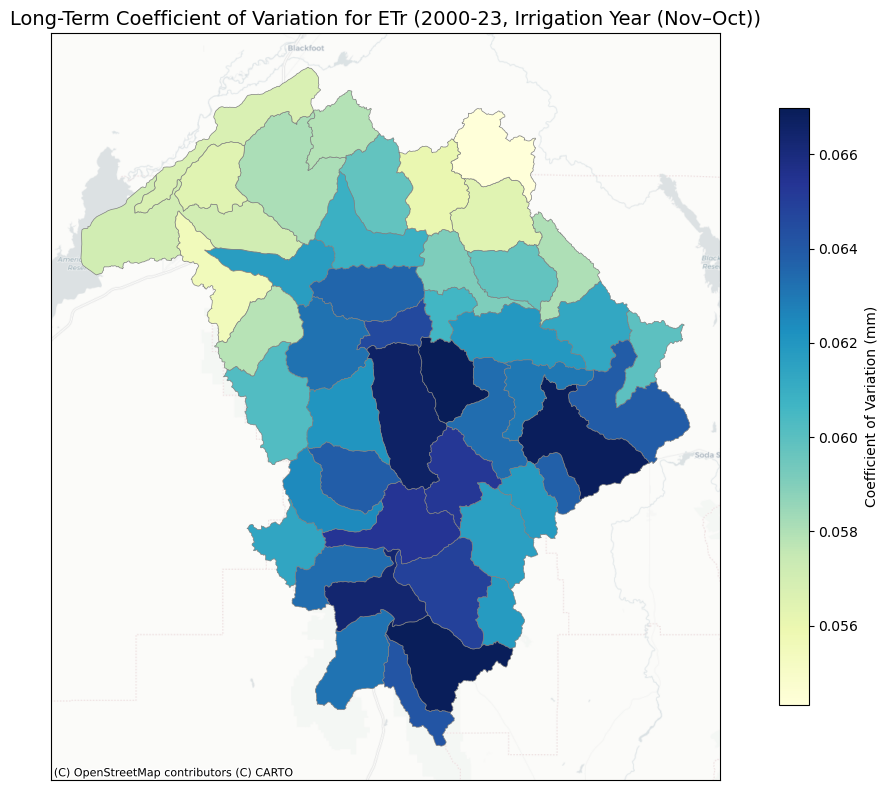

In [150]:
plot_gdf(
    huc12_gdf,
    column='et_cv',
    cmap='YlGnBu',
    legend_label='Coefficient of Variation (mm)',
    figsize=(12, 8),
    basemap=True,
    save_path='graphics/etr_cv_gmet_huc12.png', #'ppt_mean_map.png',
    title='Long-Term Coefficient of Variation for ETr (2000-23, Irrigation Year (Nov–Oct))'
)


In [137]:
agg_huc8 = agg_irr_year.groupby(['irr_year']).agg(
    ppt_bas_total=('ppt_total', 'mean'),   # Mean total precipitation across all HUC12s for each year
    ppt_bas_std=('ppt_total', 'std'),      # Standard deviation of total precipitation
    ppt_bas_cv=('ppt_total', lambda x: x.std() / x.mean() if x.mean() != 0 else np.nan),  # CV for total precipitation
    
    tmin_bas_mean=('tmin_mean', 'mean'),   # Mean of minimum temperature
    tmin_bas_std=('tmin_mean', 'std'),     # Standard deviation of minimum temperature
    tmin_bas_cv=('tmin_mean', lambda x: x.std() / x.mean() if x.mean() != 0 else np.nan),  # CV for minimum temperature
    
    tmax_bas_mean=('tmax_mean', 'mean'),   # Mean of maximum temperature
    tmax_bas_std=('tmax_mean', 'std'),     # Standard deviation of maximum temperature
    tmax_bas_cv=('tmax_mean', lambda x: x.std() / x.mean() if x.mean() != 0 else np.nan),  # CV for maximum temperature
    
    et_bas_total=('et_total', 'mean'),     # Mean total ET across all HUC12s
    et_bas_std=('et_total', 'std'),        # Standard deviation of total ET
    et_bas_cv=('et_total', lambda x: x.std() / x.mean() if x.mean() != 0 else np.nan)    # CV for ET totals
).reset_index()


In [138]:
agg_huc8

,irr_year,ppt_bas_total,ppt_bas_std,ppt_bas_cv,tmin_bas_mean,tmin_bas_std,tmin_bas_cv,tmax_bas_mean,tmax_bas_std,tmax_bas_cv,et_bas_total,et_bas_std,et_bas_cv
0,2000,438.057737,119.618189,0.273065,1.006262,0.729887,0.725345,15.184102,1.047334,0.068976,1762.019724,81.927031,0.046496
1,2001,314.810480,87.621535,0.278331,-0.297881,0.733548,-2.462557,14.104859,0.903819,0.064079,1711.775918,72.740950,0.042494
2,2002,464.939745,133.242488,0.286580,-0.662883,0.683479,-1.031069,13.228172,0.891814,0.067418,1613.550587,66.508182,0.041219
3,2003,360.515531,102.588206,0.284560,1.477668,0.719962,0.487228,15.192195,1.016016,0.066878,1712.460988,73.321741,0.042817
4,2004,613.150294,147.995557,0.241369,0.655036,0.797088,1.216861,13.281786,0.933941,0.070317,1522.554167,62.364225,0.040960
5,2005,544.341554,106.311739,0.195303,0.696401,0.859118,1.233655,13.804877,0.859063,0.062229,1526.999314,65.090127,0.042626
6,2006,652.975713,163.145852,0.249850,0.693631,0.784825,1.131472,13.834750,0.890394,0.064359,1590.629144,71.401158,0.044889
7,2007,448.467832,105.662108,0.235607,1.168342,0.772679,0.661346,14.763029,0.913979,0.061910,1725.909607,77.917600,0.045146
8,2008,433.419628,136.014210,0.313816,-0.033928,0.745840,-21.982821,13.246288,0.885859,0.066876,1654.884664,69.220447,0.041828
9,2009,672.225264,173.478668,0.258066,0.542845,0.730236,1.345202,13.262790,0.882303,0.066525,1476.833388,61.933317,0.041937


In [140]:
def plot_timeseries_with_std(df, year_col, mean_col, std_col, ylabel, title, color='tab:blue', save_path=None):
    years = df[year_col]
    mean = df[mean_col]
    std = df[std_col]

    fig, ax = plt.subplots(figsize=(10, 6))

    # Fill ±1 std
    ax.fill_between(years, mean - std, mean + std, color=color, alpha=0.3, label='±1 Std Dev')

    # Plot mean line
    ax.plot(years, mean, color=color, marker='o', label='Mean')

    # Labels and aesthetics
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Irrigation Year")
    ax.set_ylabel(ylabel)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend()
    ax.set_axisbelow(True)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()


Saved: graphics/annual_ppt_huc8_gmet.png


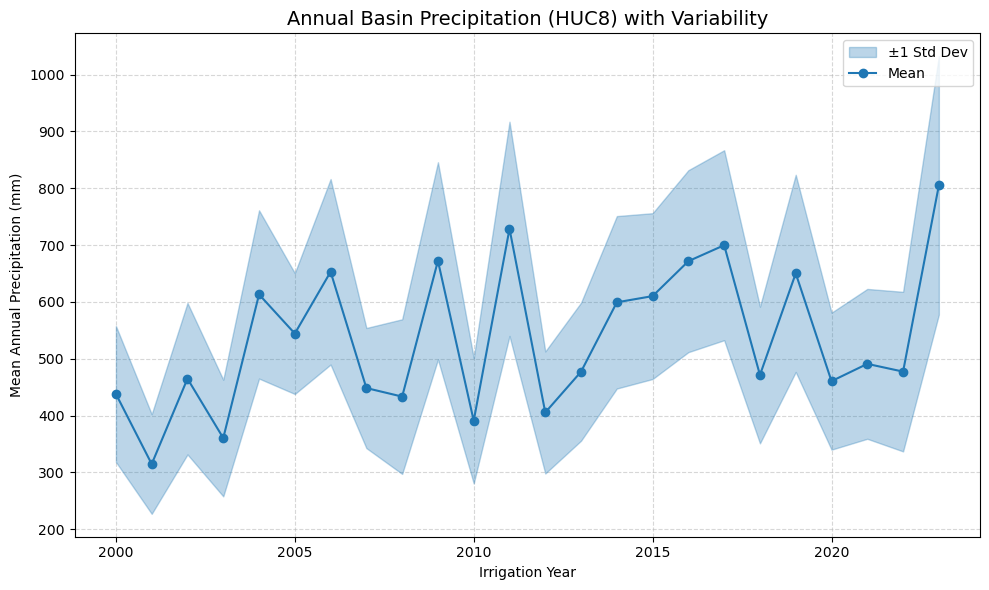

In [152]:
plot_timeseries_with_std(
    df=agg_huc8,
    year_col='irr_year',
    mean_col='ppt_bas_total',
    std_col='ppt_bas_std',
    ylabel='Mean Annual Precipitation (mm)',
    title='Annual Basin Precipitation (HUC8) with Variability',
    color='tab:blue',
    save_path='graphics/annual_ppt_huc8_gmet.png'
)


Saved: graphics/annual_etr_huc8_gmet.png


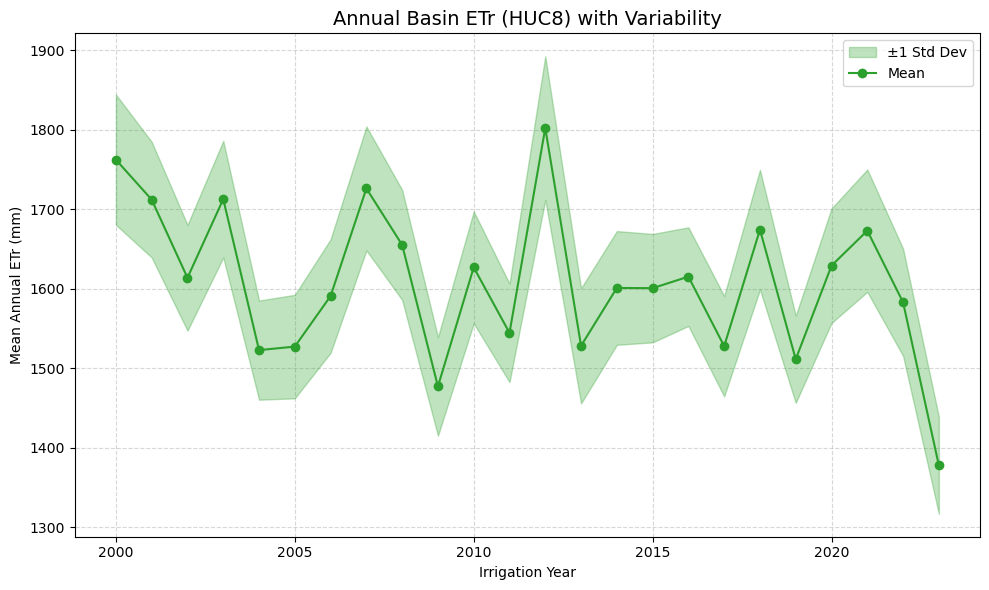

In [153]:
plot_timeseries_with_std(
    df=agg_huc8,
    year_col='irr_year',
    mean_col='et_bas_total',
    std_col='et_bas_std',
    ylabel='Mean Annual ETr (mm)',
    title='Annual Basin ETr (HUC8) with Variability',
    color='tab:green',
    save_path='graphics/annual_etr_huc8_gmet.png'
)


In [44]:
# Reshape the dataframe using pd.melt to have three columns: year, value, and variable
df_long = pd.melt(agg_huc8, 
                  id_vars=['irr_year'], 
                  value_vars=['ppt_bas_total', 'tmin_bas_mean', 'tmax_bas_mean', 'tavg_bas_mean', 'et_bas_total'],
                  var_name='variable', 
                  value_name='value')

# Optional: You may want to create a mapping for better variable labels
df_long['variable'] = df_long['variable'].replace({
    'ppt_bas_total': 'Precipitation (Total)',
    'tmin_bas_mean': 'Min Temperature (Mean)',
    'tmax_bas_mean': 'Max Temperature (Mean)',
    'tavg_bas_mean': 'Avg Temperature (Mean)',
    'et_bas_total': 'Evapotranspiration (Total)'
})

# Display the reshaped dataframe
df_long


,irr_year,variable,value
0,2000,Precipitation (Total),438.057737
1,2001,Precipitation (Total),314.810480
2,2002,Precipitation (Total),464.939745
3,2003,Precipitation (Total),360.515531
4,2004,Precipitation (Total),613.150294
...,...,...,...
115,2019,Evapotranspiration (Total),1510.999048
116,2020,Evapotranspiration (Total),1628.776970
117,2021,Evapotranspiration (Total),1672.796607
118,2022,Evapotranspiration (Total),1582.716472


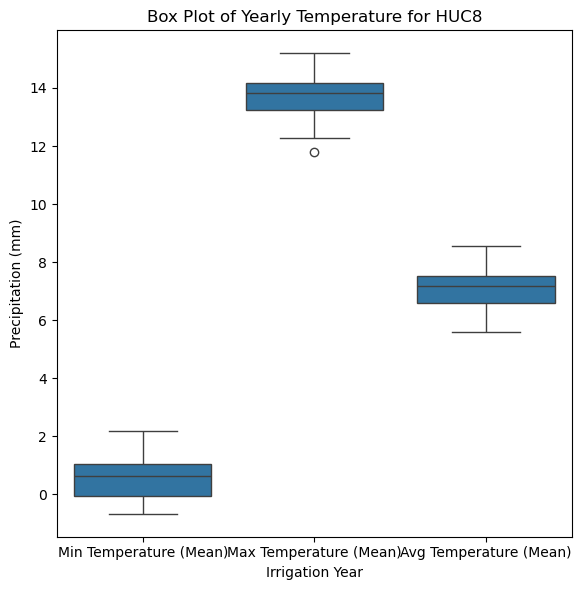

In [45]:

plt.figure(figsize=(6, 6))
sns.boxplot(x='variable', y='value', data=df_long[df_long['variable'].isin(['Min Temperature (Mean)', 'Max Temperature (Mean)', 'Avg Temperature (Mean)'])], orient='v')
plt.title('Box Plot of Yearly Temperature for HUC8')
plt.xlabel('Irrigation Year')
plt.ylabel('Precipitation (mm)')
plt.tight_layout()
plt.show()


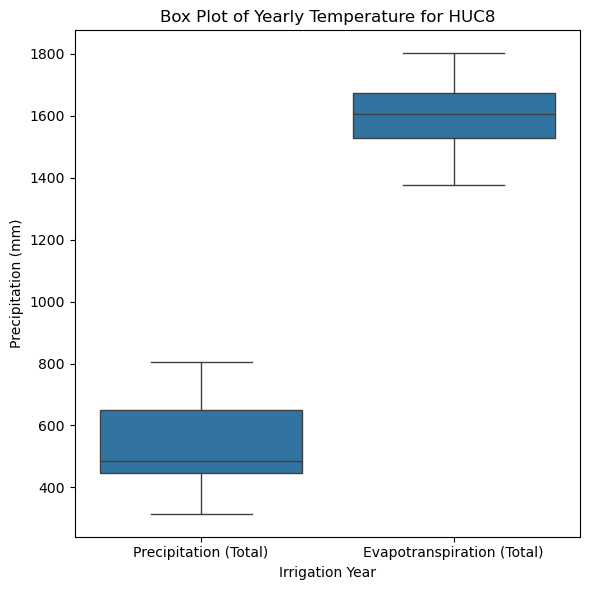

In [46]:

plt.figure(figsize=(6, 6))
sns.boxplot(x='variable', y='value', data=df_long[df_long['variable'].isin(['Precipitation (Total)', 'Evapotranspiration (Total)'])], orient='v')
plt.title('Box Plot of Yearly Temperature for HUC8')
plt.xlabel('Irrigation Year')
plt.ylabel('Precipitation (mm)')
plt.tight_layout()
plt.show()
